In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.metrics import f1_score

%pylab inline

train_df = pd.read_csv('../input/train_set.csv', sep='\t', nrows=None)
test_df = pd.read_csv('../input/test_a.csv', sep='\t', nrows=None)

Populating the interactive namespace from numpy and matplotlib


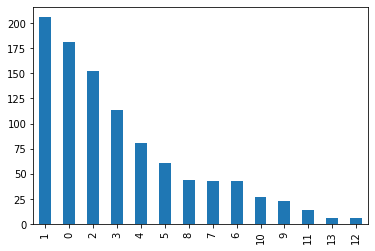

In [7]:
train_df['label'].value_counts().plot(kind='bar')

# 统计最多多少个字符

In [37]:
all_lines = ' '.join(train_df['text']) + ' ' + ' '.join(test_df['text'])
all_words = np.array(all_lines.split()).astype(int)

In [38]:
all_words.max()

7549

# 统计每类新闻字符个数

In [39]:
train_df['text'] = train_df['text'].apply(lambda x: np.array(x.split(' ')).astype(int))
test_df['text'] = test_df['text'].apply(lambda x: np.array(x.split(' ')).astype(int))

In [65]:
all_word_vec = np.zeros((14, 7550), dtype=np.float32)

for row in train_df.itertuples():
    all_word_vec[row.label, row.text] += 1
    
all_word_vec /= train_df.shape[0]

In [74]:
for idx in range(14):
    print(idx, all_word_vec[idx].argsort()[-10:])

0 [4811 3659 4464 7399 3370 6122 2465  648  900 3750]
1 [6065  299 4853 2465 3659  648 4464 3370 3750  900]
2 [4939 5598 5445 4704 6122 2465 7399  648  900 3750]
3 [ 669 4811 4853 4893 6122 7399 2465  648  900 3750]
4 [2400 4411 6122 4464 2073 7399  648 4853 3750  900]
5 [ 299 5977 4659 5598 4893 7399 6122  648 3750  900]
6 [6122 2555 6248 1519 1699 4811 5620  648  900 3750]
7 [ 299 2400 4811 3659 4464 1699 3370  648 3750  900]
8 [5598  669  913 4811 4939 7399 6122  900 3750  648]
9 [2109 5598 4939 4811 7328 6122 7399  900  648 3750]
10 [ 299 4464 2465 3370 1699 3686  648  885 3750  900]
11 [4893 7399 4811  669 4939 7539 6122  900  648 3750]
12 [6065 5602 2400 2465 3659 7539  900 3750 4464 3370]
13 [3864 3870 4939  900 1580 7539 5491 2662 3750  648]


In [87]:
np.where(train_df['text'].iloc[0] == 3750)

(array([  35,   48,   64,   74,  106,  115,  153,  168,  178,  185,  216,
         244,  251,  264,  286,  291,  302,  331,  347,  361,  387,  418,
         431,  441,  466,  505,  512,  521,  532,  548,  564,  577,  586,
         613,  616,  622,  634,  679,  697,  721,  745,  755,  761,  782,
         793,  803,  828,  836,  842,  856,  861,  884,  897,  924,  928,
         939,  949,  963,  968,  980, 1011, 1029, 1044, 1051]),)

In [88]:
np.where(train_df['text'].iloc[0] == 900)

(array([  61,   96,  141,  198,  237,  258,  279,  313,  378,  403,  457,
         481,  490,  557,  597,  631,  647,  667,  703,  713,  775,  809,
         849,  869,  891,  910,  976, 1018, 1047, 1055]),)

In [96]:
all_word_vec.sum(0).argsort()[-10:]

array([3659, 1699, 4464, 4811, 7399, 6122, 2465,  648,  900, 3750])

# baseline加强版

In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

train_df = pd.read_csv('../input/train_set.csv', sep='\t', nrows=None)
test_df = pd.read_csv('../input/test_a.csv', sep='\t', nrows=None)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000).fit(train_df['text'].iloc[:].values)
train_tfidf = tfidf.transform(train_df['text'].iloc[:].values)
test_tfidf = tfidf.transform(test_df['text'].iloc[:].values)

skf = StratifiedKFold(n_splits=5, random_state=7) 
test_pred = np.zeros((test_tfidf.shape[0], 14), dtype=np.float32)  
for idx, (train_index, valid_index) in enumerate(skf.split(train_tfidf, train_df['label'].values)):

    x_train_, x_valid_ = train_tfidf[train_index], train_tfidf[valid_index]
    y_train_, y_valid_ = train_df['label'].values[train_index], train_df['label'].values[valid_index]
    
    clf = LGBMClassifier()
    clf.fit(x_train_, y_train_)
    val_pred = clf.predict(x_valid_)
    
    print(f1_score(y_valid_, val_pred, average='macro'))
    test_pred += clf.predict_proba(test_tfidf)

/root/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9347219118943704
0.9331967081981244
0.9326927616561106


In [111]:
test_pred

array([[2.43331306e-03, 4.98582077e+00, 8.70002899e-04, ...,
        1.79282186e-04, 3.83838706e-05, 1.42652807e-05],
       [9.62744525e-04, 5.30660851e-04, 4.99282217e+00, ...,
        1.09481793e-04, 5.39226567e-05, 3.21293896e-06],
       [6.14396529e-03, 1.20122253e-03, 4.03519371e-04, ...,
        2.68263917e-04, 1.42693880e-05, 5.24245479e-06],
       ...,
       [1.52684171e-02, 4.40746832e+00, 5.02393302e-03, ...,
        1.00517226e-03, 2.04726894e-04, 7.74227083e-05],
       [1.22115649e-02, 1.91734277e-03, 1.79137068e-03, ...,
        1.72756307e-04, 1.54060166e-04, 1.05225445e-05],
       [1.18725467e-02, 4.96777058e+00, 7.75435183e-04, ...,
        1.73424472e-04, 2.99724416e-05, 1.18266225e-05]], dtype=float32)

In [113]:
df = pd.DataFrame()
df['label'] = test_pred.argmax(1)
df.to_csv('submit.csv', index=None)

# TFIDF

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
- http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())
print(X2.toarray())

[u'and', u'document', u'first', u'is', u'one', u'second', u'the', u'third', u'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
[u'and', u'and this', u'document', u'document is', u'first', u'first document', u'is', u'is the', u'is this', u'one', u'second', u'second document', u'the', u'the first', u'the second', u'the third', u'third', u'third one', u'this', u'this document', u'this is', u'this the']
[[0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 0 2 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0]
 [0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1]]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

# FastText

In [16]:
train_df = pd.read_csv('../input/train_set.csv', sep='\t', nrows=None)
train_df['label_ft'] = '__label__' + train_df['label'].astype(str)
train_df[['text','label_ft']].iloc[:-5000].to_csv('train.csv', index=None, header=None, sep='\t')

In [17]:
import fasttext
model = fasttext.train_supervised('train.csv', lr=1.0, wordNgrams=5, 
                                  verbose=2, minCount=1, epoch=25, loss="hs")

val_pred = [model.predict(x)[0][0].split('__')[-1] for x in train_df.iloc[-5000:]['text']]
print(f1_score(train_df['label'].values[-5000:].astype(str), val_pred, average='macro'))

0.9165102301726077
